In [1]:
import os

os.environ['DDE_BACKEND'] = 'tensorflow'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(42)
np.random.seed(42)

from deepxde.data import PDE
from deepxde.geometry import TimeDomain
from deepxde.icbc.initial_conditions import IC
from deepxde.icbc import PointSetBC
from deepxde.nn import FNN, PFNN
from deepxde.model import Model
from deepxde.callbacks import VariableValue, EarlyStopping
from deepxde.metrics import mean_squared_error, l2_relative_error
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

from tensorflow.keras.optimizers.schedules import InverseTimeDecay

import sys
sys.path.append('../..')
from utils.custom_models import AdaptativeDataWeightModel

2025-11-23 14:52:54.326093: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



Set the default float type to float64


In [2]:


def sir_system(t, compartments, gamma):
    S, I, R = compartments
    return [
        -beta_t(t) * S * I,
        beta_t(t) * S * I - gamma * I,
        gamma * I
    ]

In [3]:
t0, tf = 0, 50

beta1 = 0.1
beta0 = 0.25
omega = 0.44
phi = 0.0

beta_t = lambda t: beta1 * np.sin(omega * t + phi) + beta0

gamma = 0.1 
S0, I0, R0 = 0.99, 0.01, 0.0
beta_0 = beta_t(0)

In [4]:
sir_sol = solve_ivp(
    sir_system,
    [t0, tf],
    [S0, I0, R0],
    args=[gamma],
    dense_output=True
)

nop_data = 100
train_t = np.linspace(t0, tf, nop_data)
sir_data = sir_sol.sol(train_t).T

In [5]:
noise_std = 0.02
sir_data += np.random.normal(scale=noise_std, size=(nop_data, 3))
sir_data[sir_data < 0] = 0
sir_data[sir_data > 1] = 1

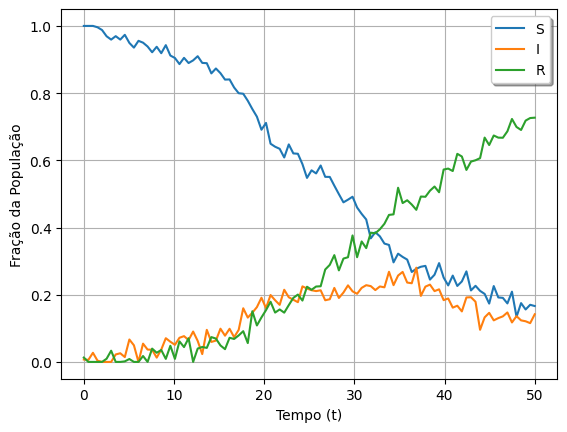

In [6]:
plt.plot(train_t, sir_data)
plt.legend(["S", "I", "R"], shadow=True)
plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")
plt.grid()
plt.savefig("../../images/rk-compartiments-sen-beta-noisy.png")
plt.show()

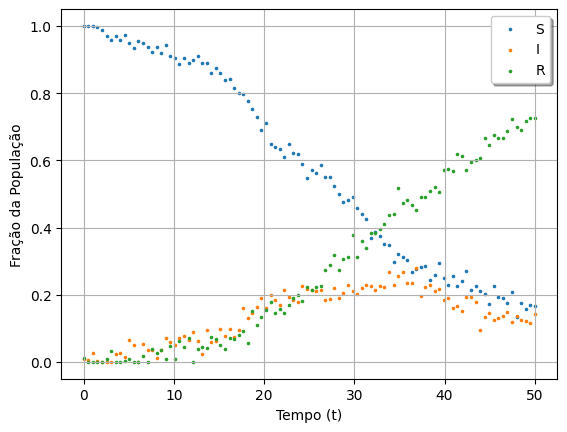

In [7]:
plt.scatter(train_t, sir_data[:, 0], s=2.5)
plt.scatter(train_t, sir_data[:, 1], s=2.5)
plt.scatter(train_t, sir_data[:, 2], s=2.5)
plt.legend(["S", "I", "R"], shadow=True)
plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")
plt.grid()
plt.savefig("../../images/rk-data-sen-beta-noisy.png")
plt.show()

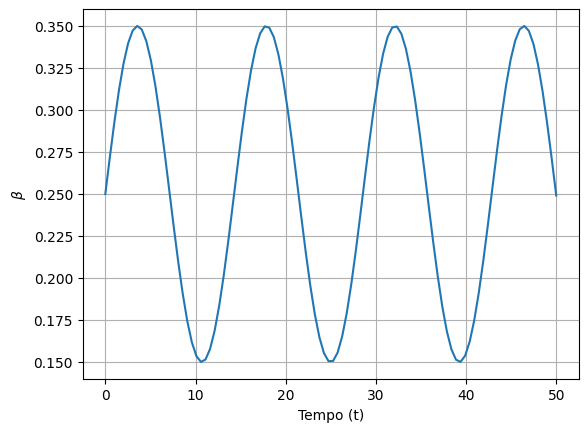

In [8]:

plt.plot(train_t, beta_t(train_t))
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.grid()
plt.savefig("../../images/real-beta-sen-beta-noisy.png")
plt.show()

In [9]:
timeinterval = TimeDomain(t0, tf)

def sir_residual(t, y):
    S, I, beta = y[:,0:1], y[:,1:2], y[:,2:3]

    dS_dt = dde.gradients.jacobian(y, t, i=0)
    dI_dt = dde.gradients.jacobian(y, t, i=1)
    
    return [
        dS_dt + beta * S * I,
        dI_dt - beta * S * I + gamma * I
    ]

# Tensorflow has an issue with lambdas...
def is_on_initial(_, on_initial): return on_initial
def S0_val(_): return S0
def I0_val(_): return I0
def beta0_val(_): return beta_0

ic_S = IC(timeinterval, S0_val, is_on_initial, component=0)
ic_I = IC(timeinterval, I0_val, is_on_initial, component=1)

data_t = train_t.reshape(-1, 1)
data_S = PointSetBC(data_t, sir_data[:,0:1], component=0)
data_I = PointSetBC(data_t, sir_data[:,1:2], component=1)

ics = [ic_S, ic_I]

data_conds = [
    data_I 
] 

conditions = ics + data_conds

data = PDE(
    timeinterval, 
    sir_residual, 
    conditions,
    num_domain=128,
    num_boundary=2,
    num_test=32,
    anchors=data_t
)

n_hidden_layers = 4
hidden_layer_size = 50
topology = [1] + [hidden_layer_size] * n_hidden_layers + [3]
# activation = ["tanh"] * n_hidden_layers + ["sigmoid"]
activation = "tanh"
# activation = "ReLU"
initializer = "Glorot normal"
optimizer = "adam"
lr = 0.002

eq_w = 1
ic_w = 1
data_w = 1

n_equations = 2

loss_weights = [eq_w] * n_equations + [ic_w] * len(ics) + [data_w] * len(data_conds)

# net = FNN(
#     topology, 
#     activation, 
#     initializer
# )

net = PFNN(
    topology, 
    activation, 
    initializer
)

model = AdaptativeDataWeightModel(data, net, n_physics=n_equations + len(ics), n_data=1)
# model = Model(data, net)

model.compile(
    optimizer, 
    lr,
    loss_weights=loss_weights
)


Compiling model...
'compile' took 0.009631 s



2025-11-23 14:52:58.926117: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1763920378.926853 1013078 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2591 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [10]:
early_stopping = EarlyStopping(min_delta=1e-5, patience=10000)

losshistory, train_state = model.train(
    iterations=250000, 
    display_every=100,
    callbacks=[early_stopping]
)

# model.compile(
#     "L-BFGS", 
#     loss_weights=loss_weights
# )

# dde.optimizers.set_LBFGS_options(
#     # ftol=np.finfo(float).eps,
#     maxiter=25000,
#     ftol=1e-10,
#     gtol=1e-12
# )

# losshistory, train_state = model.train(
#     iterations=20000, 
#     display_every=100
# )

Training model...



2025-11-23 14:53:00.919799: I external/local_xla/xla/service/service.cc:163] XLA service 0x5581edaf0f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-23 14:53:00.919817: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-11-23 14:53:00.927372: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-23 14:53:00.996861: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1763920381.304414 1013078 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                            Test loss                                             Test metric
0         [1.24e-01, 8.12e-02, 9.80e-01, 1.00e-04, 5.19e-01]    [1.21e-01, 8.18e-02, 9.80e-01, 1.00e-04, 5.19e-01]    []  
100       [1.77e-04, 7.65e-05, 2.19e-07, 9.87e-06, 1.66e-03]    [7.68e-05, 6.46e-05, 2.19e-07, 9.87e-06, 1.66e-03]    []  
200       [1.21e-04, 5.74e-05, 5.75e-09, 3.53e-10, 1.57e-03]    [5.00e-05, 5.54e-05, 5.75e-09, 3.53e-10, 1.57e-03]    []  
300       [1.08e-04, 4.82e-05, 2.82e-09, 7.54e-11, 1.46e-03]    [4.97e-05, 4.83e-05, 2.82e-09, 7.54e-11, 1.46e-03]    []  
400       [9.64e-05, 4.43e-05, 1.59e-09, 1.26e-10, 1.33e-03]    [4.81e-05, 4.48e-05, 1.59e-09, 1.26e-10, 1.33e-03]    []  
500       [8.41e-05, 4.16e-05, 8.56e-10, 1.26e-10, 1.18e-03]    [4.47e-05, 4.20e-05, 8.56e-10, 1.26e-10, 1.18e-03]    []  
600       [7.12e-05, 3.81e-05, 3.31e-10, 5.70e-11, 1.02e-03]    [3.98e-05, 3.81e-05, 3.31e-10, 5.70e-11, 1.02e-03]    []  
700      

In [11]:
model.save("../../models/sen-beta-noisy")

'../../models/sen-beta-noisy-33000.weights.h5'

In [12]:
dde.saveplot(
    losshistory, 
    train_state, 
    issave=True, 
    isplot=False,
    output_dir="../../losses", 
    loss_fname=f"loss-sen-beta-noisy",
    train_fname=f"train-sen-beta-noisy",
    test_fname=f"test-sen-beta-noisy")

Saving loss history to ../../losses/loss-sen-beta-noisy ...
Saving training data to ../../losses/train-sen-beta-noisy ...
Saving test data to ../../losses/test-sen-beta-noisy ...


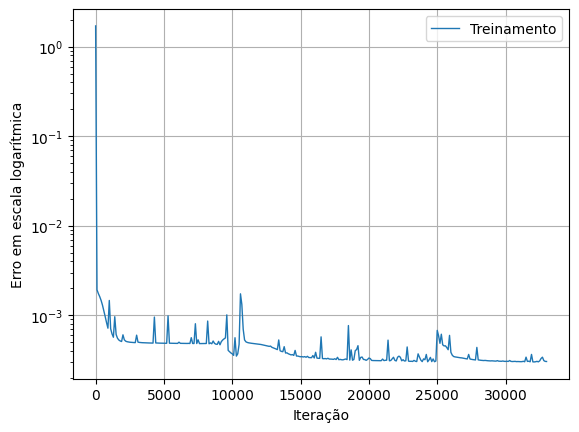

In [13]:
train = np.sum(losshistory.loss_train, axis=1)
test = np.sum(losshistory.loss_test, axis=1)

plt.semilogy(losshistory.steps, train, "-", label="Treinamento", linewidth=1)
# plt.semilogy(losshistory.steps, train, "o-", label="Treinamento", linewidth=2)
# plt.semilogy(losshistory.steps, test, "x-", label="Teste", linewidth=2)

plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")

plt.legend()
plt.grid()
plt.savefig(f"../../images/loss-sen-beta-noisy.png")
plt.show()

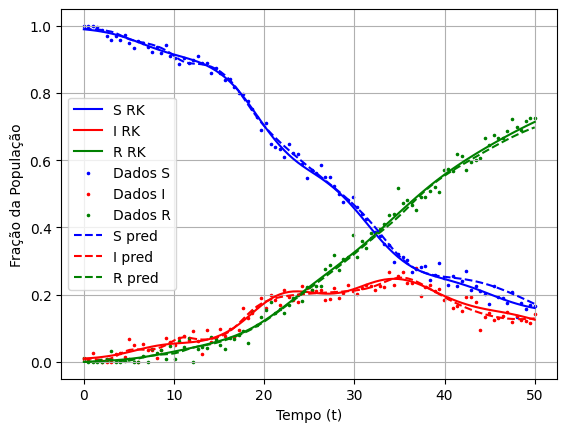

In [14]:
plt.rcParams['text.usetex'] = False
nop_test = 100

test_t = np.linspace(t0, tf, nop_test).reshape(-1, 1)
y_pred = model.predict(test_t)

S_pred, I_pred = y_pred[:, 0], y_pred[:, 1]
R_pred = 1 - S_pred - I_pred  

sir_test = sir_sol.sol(test_t.reshape(nop_test)).T

S_real = sir_test[:,0]
I_real = sir_test[:,1]
R_real = sir_test[:,2]

plt.plot(train_t, S_real, label="S RK", color="blue")
plt.plot(train_t, I_real, label="I RK", color="red")
plt.plot(train_t, R_real, label="R RK", color="green")

plt.scatter(train_t, sir_data[:,0], label="Dados S", color="blue", s=2.5)
plt.scatter(train_t, sir_data[:,1], label="Dados I", color="red", s=2.5)
plt.scatter(train_t, sir_data[:,2], label="Dados R", color="green", s=2.5)

plt.plot(test_t, S_pred, label="S pred", linestyle="--", color="blue")
plt.plot(test_t, I_pred, label="I pred", linestyle="--", color="red")
plt.plot(test_t, R_pred, label="R pred", linestyle="--", color="green")

plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")

plt.legend()
plt.grid()
plt.savefig("../../images/predicted-compartments-sen-beta-noisy.png")

plt.show()

[]

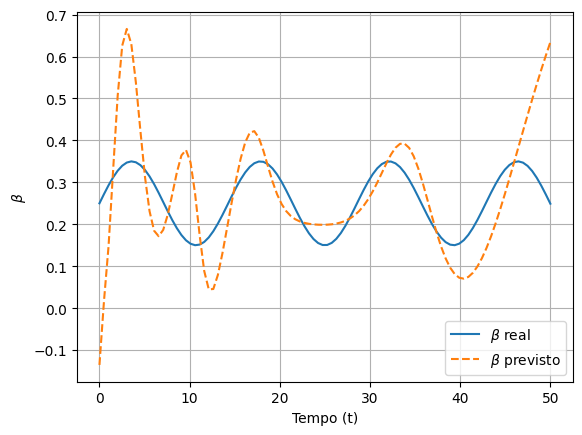

In [15]:
beta_pred = y_pred[:, 2]
beta_real = beta_t(test_t)
plt.plot(test_t, beta_real, label=r"$\beta$ real")
plt.plot(test_t, beta_pred, label=r"$\beta$ previsto", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.legend()
plt.grid()
plt.savefig("../../images/predicted-beta-sen-beta-noisy.png")
plt.plot()

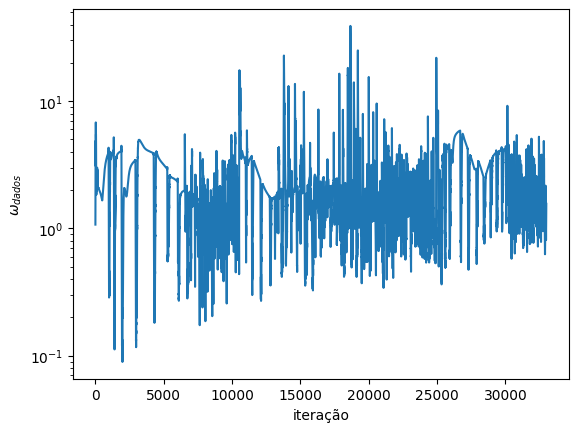

In [16]:
plt.semilogy(np.arange(len(model.data_weight_hist)), model.data_weight_hist)
plt.xlabel("iteração")
plt.ylabel("$\omega_{dados}$")
plt.savefig("../../images/data-weight-sen-beta-noisy.png")
plt.show()

In [17]:
sir_test = sir_sol.sol(test_t.reshape(nop_test)).T

S_real = sir_test[:,0]
I_real = sir_test[:,1]
R_real = 1 - S_real - I_real

### MSE

In [18]:
mean_squared_error(S_real, S_pred)

0.0001424243549872201

In [19]:
mean_squared_error(I_real, I_pred)

6.591120340114558e-05

In [20]:
mean_squared_error(R_real, R_pred)

3.735400423791792e-05

In [21]:
mean_squared_error(beta_real, beta_pred)

0.014615004977282466

### L2

In [22]:
l2_relative_error(S_real, S_pred)

np.float64(0.018334825933813165)

In [23]:
l2_relative_error(I_real, I_pred)

np.float64(0.0503122689366456)

In [24]:
l2_relative_error(R_real, R_pred)

np.float64(0.016578745502958837)

In [25]:
l2_relative_error(beta_real, beta_pred)

np.float64(6.153616881109356)

### L-Infinity

In [26]:
np.max(np.abs(S_real - S_pred))

np.float64(0.027887625050238313)

In [27]:
np.max(np.abs(I_real - I_pred))

np.float64(0.01746034853062456)

In [28]:
np.max(np.abs(R_real - R_pred))

np.float64(0.01616986760545347)

In [29]:
np.max(np.abs(beta_real - beta_pred))

np.float64(0.5157427874608487)